### 1. Set Up Environment

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, ZeroPadding2D, BatchNormalization, Input, Activation, Add, GlobalAveragePooling1D, AveragePooling2D
from tensorflow.keras.models import Sequential


from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import os
import zipfile
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

import sys
print("Python Version:", sys.version)
print("Tensorflow Version", tf.__version__)

Python Version: 3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
Tensorflow Version 2.10.0


### 2. Set up GPU running for Tensorflow

In [4]:
# Set up for using GPU (don't recommend if your GPU efficiency is lower than CPU)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    # Set only the first GPU device to be visible
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print(f"Using only GPU device {physical_devices[0].name}\n")
else:
    print("No physical GPU devices found! \n")

# Verify GPU visibility in TensorFlow
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

No physical GPU devices found! 

GPU is not available


### 3. Handle Base Furniture Dataset
#### 3.1. Data Preparation

In [12]:
furniture_df = pd.read_csv("../furniture_data.csv")

furniture_df

,Furniture_Category,Furniture_Type,Image_Path
0,beds,Asian,../Furniture_Data\beds\Asian\19726asian-daybed...
1,beds,Asian,../Furniture_Data\beds\Asian\20027asian-canopy...
2,beds,Asian,../Furniture_Data\beds\Asian\20109asian-panel-...
3,beds,Asian,../Furniture_Data\beds\Asian\20508asian-platfo...
4,beds,Asian,../Furniture_Data\beds\Asian\20750asian-comfor...
...,...,...,...
90079,tables,Victorian,../Furniture_Data\tables\Victorian\5victorian-...
90080,tables,Victorian,../Furniture_Data\tables\Victorian\6victorian-...
90081,tables,Victorian,../Furniture_Data\tables\Victorian\7victorian-...
90082,tables,Victorian,../Furniture_Data\tables\Victorian\8victorian-...


In [15]:
furniture_df['Furniture_Category_Type'] = furniture_df['Furniture_Category'] + '-' + furniture_df['Furniture_Type']

furniture_df

,Furniture_Category,Furniture_Type,Image_Path,Furniture_Category_Type
0,beds,Asian,../Furniture_Data\beds\Asian\19726asian-daybed...,beds-Asian
1,beds,Asian,../Furniture_Data\beds\Asian\20027asian-canopy...,beds-Asian
2,beds,Asian,../Furniture_Data\beds\Asian\20109asian-panel-...,beds-Asian
3,beds,Asian,../Furniture_Data\beds\Asian\20508asian-platfo...,beds-Asian
4,beds,Asian,../Furniture_Data\beds\Asian\20750asian-comfor...,beds-Asian
...,...,...,...,...
90079,tables,Victorian,../Furniture_Data\tables\Victorian\5victorian-...,tables-Victorian
90080,tables,Victorian,../Furniture_Data\tables\Victorian\6victorian-...,tables-Victorian
90081,tables,Victorian,../Furniture_Data\tables\Victorian\7victorian-...,tables-Victorian
90082,tables,Victorian,../Furniture_Data\tables\Victorian\8victorian-...,tables-Victorian


#### 3.2. Exploration Data Analysis (EDA)

In [16]:
furniture_df.shape

(90084, 4)

In [17]:
furniture_df['Furniture_Category'].value_counts()

Furniture_Category
lamps       32402
chairs      22053
tables      17100
dressers     7871
beds         6578
sofas        4080
Name: count, dtype: int64

<Axes: xlabel='Furniture_Category'>

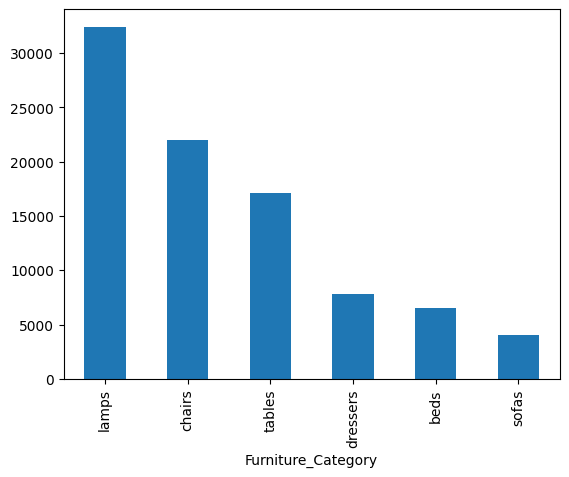

In [18]:
furniture_df['Furniture_Category'].value_counts().plot.bar()

In [20]:
furniture_df.groupby('Furniture_Category')['Furniture_Type'].value_counts()

Furniture_Category  Furniture_Type
beds                Contemporary      1953
                    Transitional      1719
                    Traditional       1397
                    Modern             380
                    Rustic             239
                                      ... 
tables              Rustic              71
                    Victorian           46
                    Scandinavian        45
                    Southwestern        27
                    Tropical            24
Name: count, Length: 102, dtype: int64

In [13]:
furniture_df['Furniture_Type'].value_counts()

Furniture_Type
Contemporary     17605
Traditional      16456
Transitional     14329
Modern            7184
Midcentury        6737
Industrial        5326
Farmhouse         3753
Beach             3734
Asian             3069
Craftsman         2968
Mediterranean     1974
Victorian         1848
Rustic            1839
Eclectic          1629
Tropical           855
Scandinavian       414
Southwestern       364
Name: count, dtype: int64

<Axes: xlabel='Furniture_Type'>

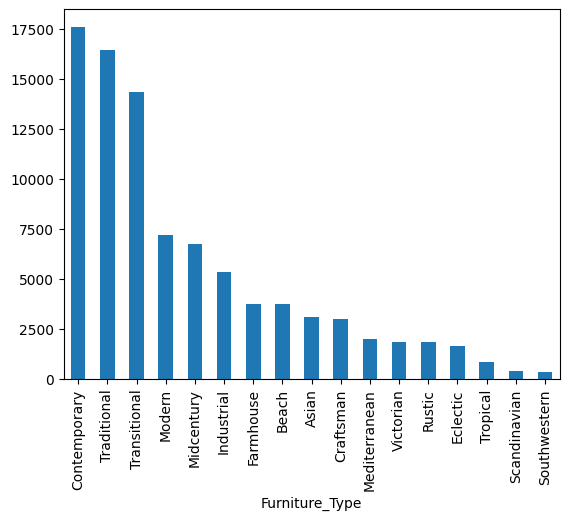

In [14]:
furniture_df['Furniture_Type'].value_counts().plot.bar()

<Axes: xlabel='Furniture_Category,Furniture_Type'>

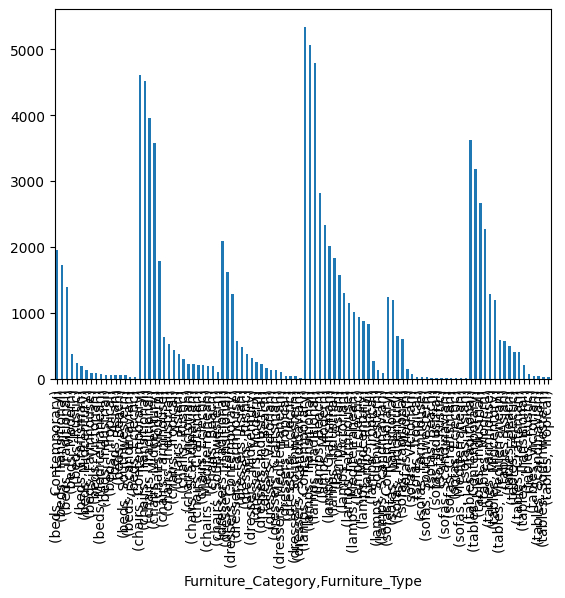

In [22]:
furniture_df.groupby('Furniture_Category')['Furniture_Type'].value_counts().plot.bar()

In [31]:
categorical_folders = furniture_df["Furniture_Category_Type"].unique()
print(categorical_folders)

num_classes = furniture_df["Furniture_Category_Type"].nunique()
print("Number of classes:", num_classes)

['beds-Asian' 'beds-Beach' 'beds-Contemporary' 'beds-Craftsman'
 'beds-Eclectic' 'beds-Farmhouse' 'beds-Industrial' 'beds-Mediterranean'
 'beds-Midcentury' 'beds-Modern' 'beds-Rustic' 'beds-Scandinavian'
 'beds-Southwestern' 'beds-Traditional' 'beds-Transitional'
 'beds-Tropical' 'beds-Victorian' 'chairs-Asian' 'chairs-Beach'
 'chairs-Contemporary' 'chairs-Craftsman' 'chairs-Eclectic'
 'chairs-Farmhouse' 'chairs-Industrial' 'chairs-Mediterranean'
 'chairs-Midcentury' 'chairs-Modern' 'chairs-Rustic' 'chairs-Scandinavian'
 'chairs-Southwestern' 'chairs-Traditional' 'chairs-Transitional'
 'chairs-Tropical' 'chairs-Victorian' 'dressers-Asian' 'dressers-Beach'
 'dressers-Contemporary' 'dressers-Craftsman' 'dressers-Eclectic'
 'dressers-Farmhouse' 'dressers-Industrial' 'dressers-Mediterranean'
 'dressers-Midcentury' 'dressers-Modern' 'dressers-Rustic'
 'dressers-Scandinavian' 'dressers-Southwestern' 'dressers-Traditional'
 'dressers-Transitional' 'dressers-Tropical' 'dressers-Victorian'
 'la

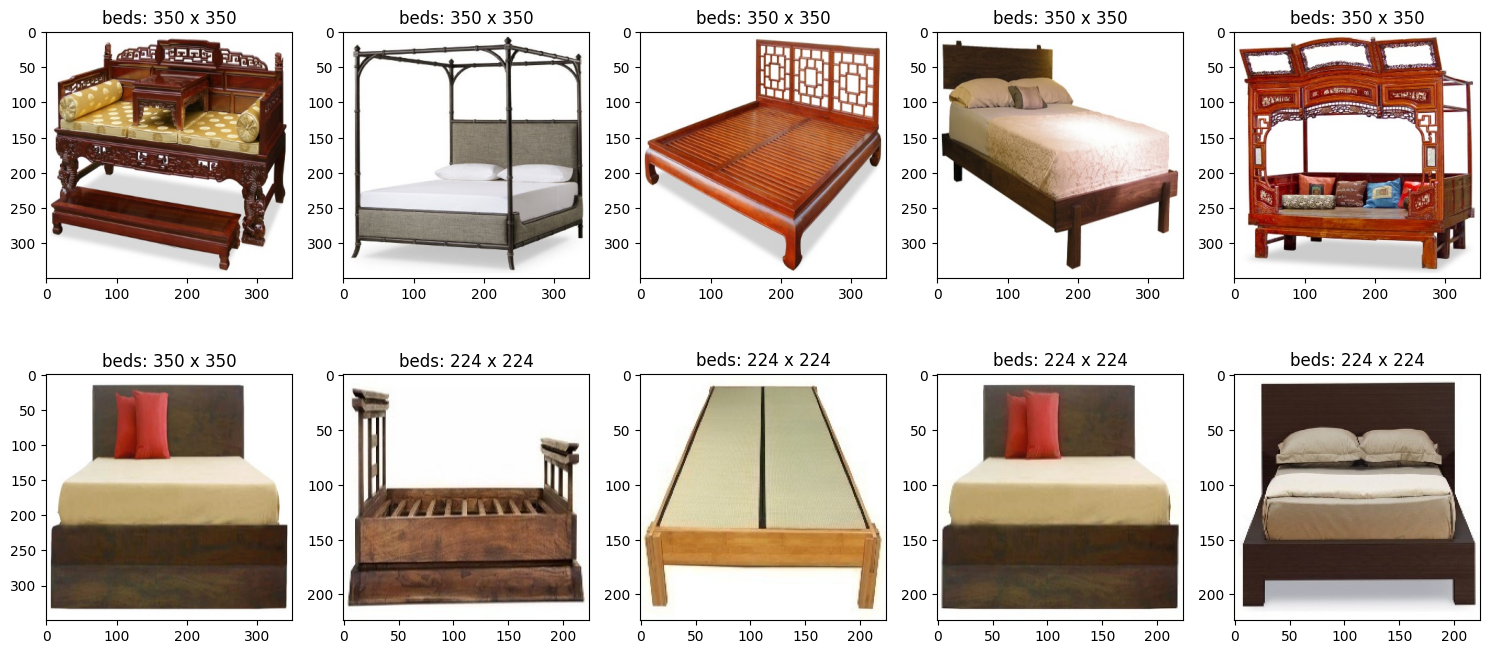

In [32]:
# Check image for image overview (contain name and size of flower images)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

for i, ax in enumerate(axes.flat):
    image_overview = Image.open(furniture_df.loc[i, "Image_Path"])
    ax.imshow(image_overview)
    
    width, height = image_overview.size
    ax.set_title(furniture_df.loc[i, "Furniture_Category"] + ": {} x {}".format(width, height))
plt.tight_layout()
plt.show()

### 4. Handle additional data from crawling website
#### 4.1 Data Preparation

#### 4.2. Exploration Data Analysis (EDA)

### 5. Group 2 dataset into 1

### 6. Split data into train and test set and prepare for data augmentation and normalization

In [33]:
dev, test = train_test_split(furniture_df,train_size=0.85, shuffle=True, random_state=333)

In [34]:
dev.shape, test.shape

((76571, 4), (13513, 4))

In [35]:
#defined
BATCH_SIZE = 32

# For AlexNet
IMG_WIDTH  = 227
IMG_HEIGHT = 227

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator( rescale=1/255.0,
                                    rotation_range=40,
                                    width_shift_range=0.05,
                                    height_shift_range=0.05,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    horizontal_flip=True,
                                    brightness_range=[0.6, 1.2],
                                    fill_mode='nearest',
                                    validation_split=0.15,                      
                                    )

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [36]:
train_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category_Type',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_ds = train_datagen.flow_from_dataframe(
    dataframe=dev,
    x_col='Image_Path',
    y_col='Furniture_Category_Type',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_ds = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Image_Path',
    y_col='Furniture_Category_Type',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 65084 validated image filenames belonging to 102 classes.
Found 11485 validated image filenames belonging to 102 classes.
Found 13513 validated image filenames.


In [37]:
print(train_ds.class_indices)

{'beds-Asian': 0, 'beds-Beach': 1, 'beds-Contemporary': 2, 'beds-Craftsman': 3, 'beds-Eclectic': 4, 'beds-Farmhouse': 5, 'beds-Industrial': 6, 'beds-Mediterranean': 7, 'beds-Midcentury': 8, 'beds-Modern': 9, 'beds-Rustic': 10, 'beds-Scandinavian': 11, 'beds-Southwestern': 12, 'beds-Traditional': 13, 'beds-Transitional': 14, 'beds-Tropical': 15, 'beds-Victorian': 16, 'chairs-Asian': 17, 'chairs-Beach': 18, 'chairs-Contemporary': 19, 'chairs-Craftsman': 20, 'chairs-Eclectic': 21, 'chairs-Farmhouse': 22, 'chairs-Industrial': 23, 'chairs-Mediterranean': 24, 'chairs-Midcentury': 25, 'chairs-Modern': 26, 'chairs-Rustic': 27, 'chairs-Scandinavian': 28, 'chairs-Southwestern': 29, 'chairs-Traditional': 30, 'chairs-Transitional': 31, 'chairs-Tropical': 32, 'chairs-Victorian': 33, 'dressers-Asian': 34, 'dressers-Beach': 35, 'dressers-Contemporary': 36, 'dressers-Craftsman': 37, 'dressers-Eclectic': 38, 'dressers-Farmhouse': 39, 'dressers-Industrial': 40, 'dressers-Mediterranean': 41, 'dressers-Mi

(32, 227, 227, 3)
(32, 102)
Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


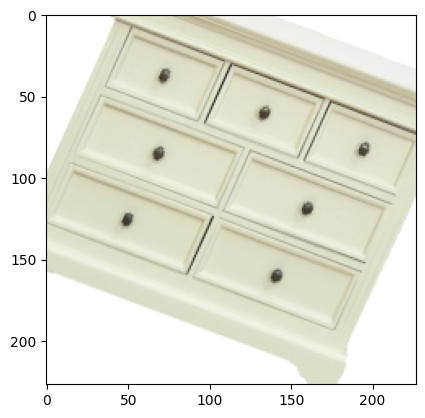

Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


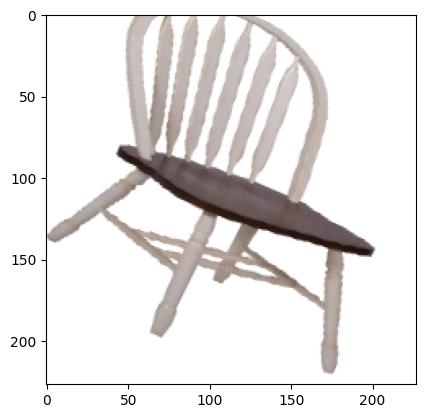

Label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


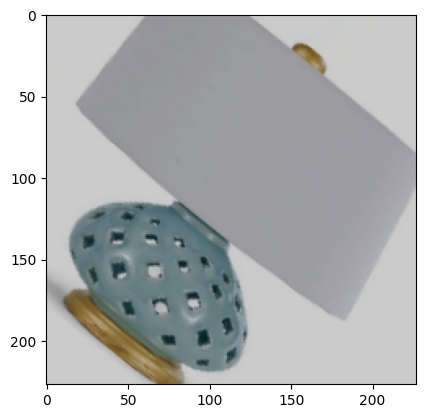

In [38]:
# Check image after data augmentation and normalization
batchX, batchY = train_ds.next()

print(batchX.shape)
print(batchY.shape)
for i in range(3):
    img = batchX[i]
    label = batchY[i]

    # print('Img: ', img)
    print('Label: ', label)

    plt.imshow(img)
    plt.show()

Model Construction Building

In [39]:
# AlexNet From Scratch
# Source: 
# - https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/
# - https://lekhuyen.medium.com/alexnet-and-image-classification-8cd8511548b4

model = Sequential([
#   Layer 1: convolutional layer + max-pooling layer
    Conv2D(96, kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2)),

#   Layer 2: convolutional layer + max-pooling layer
    Conv2D(256, kernel_size=(5,5), strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid'),

#   Layers 3-5: three convolutional layers + 1 max-pooling layer
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(384, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2,2), padding='valid'),

    Flatten(),
    Dense(units=4096, activation='relu'),
    Dropout(0.5),
    Dense(units=4096, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 384)       1

In [ ]:
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.metrics import CategoricalAccuracy, BinaryAccuracy


# For AlexNet model
# Fine tuning for SGD and Early Stopping function
optimization = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimization, 
              loss=BinaryCrossentropy(from_logits=True), 
              metrics=[BinaryAccuracy()])


early_stopping_callback = EarlyStopping(
    monitor='val_binary_accuracy',
    patience = 15,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.0001,
)

# Test with Epoch of 20
history = model.fit(train_ds, validation_data=val_ds, epochs=45, batch_size=BATCH_SIZE, callbacks=[early_stopping_callback])

In [ ]:
# Line Chart for showing loss and accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Test overall accuracy final
batchXTest, batchYTest = val_ds.next()

score = model.evaluate(batchXTest, batchYTest)

In [ ]:
# Model Structure Overview
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.save('../TrainingModels/AlexNet.h5')